In [1]:
import json, os
from fractions import Fraction

import numpy as np
import matplotlib.pyplot as plt

from utils import *

In [2]:
with open('msd-data/mfcc-features.json', 'r') as f:
    mfcc_features = json.load(f)
    for k, v in mfcc_features.items():
        mfcc_features[k] = np.array(v)

with open('msd-data/features.json', 'r') as f:
    msd_features = json.load(f)

In [37]:
def plot_avg_distances(features: set, results: str, distance_function, params: str):
    path_proportion_source: dict[tuple[int, int], list[float]] = {}
    path_proportion_target: dict[float, list[float]] = {}

    for n, r in enumerate(os.listdir(results)):
        if n % 250 == 0:
            print(f'Processing file #{n}...', end='\r')
            
        with open(f'{results}/{r}', 'r') as f:
            result = json.load(f)

        src = result['meta']['SOURCE_ID']
        trg = result['meta']['TARGET_ID'] if result['meta']['FOUND'] else result['meta']['APPROX']

        src_feats, trg_feats = features[src], features[trg]

        path = result['PATH']
        path_length = len(path)

        for i, id in enumerate(path[:-1], 1):
            feats = features[id]
            prop = Fraction(i, path_length)
            
            if not prop in path_proportion_source:
                path_proportion_source[prop] = []
            if not prop in path_proportion_target:
                path_proportion_target[prop] = []

            path_proportion_source[prop].append(distance_function(src_feats, feats))
            path_proportion_target[prop].append(distance_function(trg_feats, feats))
    
    ordered_source_keys = sorted(path_proportion_source.keys())
    ordered_target_keys = sorted(path_proportion_target.keys())

    source_points = np.array([[float(k) * 100, np.mean(path_proportion_source[k])] for k in ordered_source_keys])
    target_points = np.array([[float(k) * 100, np.mean(path_proportion_target[k])] for k in ordered_target_keys])

    distance_std = np.std(np.concatenate([source_points[:, 1], target_points[:, 1]]))
    source_points[:, 1] /= distance_std
    target_points[:, 1] /= distance_std

    ms, bs = np.polyfit(source_points[:, 0], source_points[:, 1], deg=1)
    mt, bt = np.polyfit(target_points[:, 0], target_points[:, 1], deg=1)

    source_color = '#dd1110'
    target_color = '#1011dd'

    fig, ax = plt.subplots()

    fig.set_figheight(8)
    fig.set_figwidth(8)
    ax.set_xlabel('Path progression (%)')
    ax.set_ylabel(f'Mean distance from song')
    ax.set_title(f'Distance-Straightness Scatter Plot: {params}')

    source_mse = np.mean((source_points[:, 1] - (source_points[:, 0] * ms + bs)) ** 2) #/ np.std(source_points[:, 1])
    target_mse = np.mean((target_points[:, 1] - (target_points[:, 0] * ms + bs)) ** 2) #/ np.std(target_points[:, 1])

    figtext = f'Normalized MSE for source line: {source_mse:.3f}\nNormalized MSE for target line: {target_mse:.3f}'
    fig.text(.5, -0.005, figtext, ha='center')

    plt.scatter(source_points[:, 0], source_points[:, 1], color=source_color, label='Distance to source')
    plt.scatter(target_points[:, 0], target_points[:, 1], color=target_color, label='Distance to target')

    plt.axline(xy1=(0, bs), slope=ms, color=source_color, label=f'y = {ms:.4f}x + {bs:.4f}')
    plt.axline(xy1=(0, bt), slope=mt, color=target_color, label=f'y = {mt:.4f}x + {bt:.4f}')

    plt.legend()
    plt.ylim(top=1.15 * max(max(source_points[:, 1]), max(target_points[:, 1])))

    filename = f"{'-'.join(params.split(', '))}{'' if features == msd_features else '-f=mfcc'}.png"
    plt.savefig(f'msd-results/figures/indies/{filename}', bbox_inches='tight', pad_inches=0.13)

    plt.show()


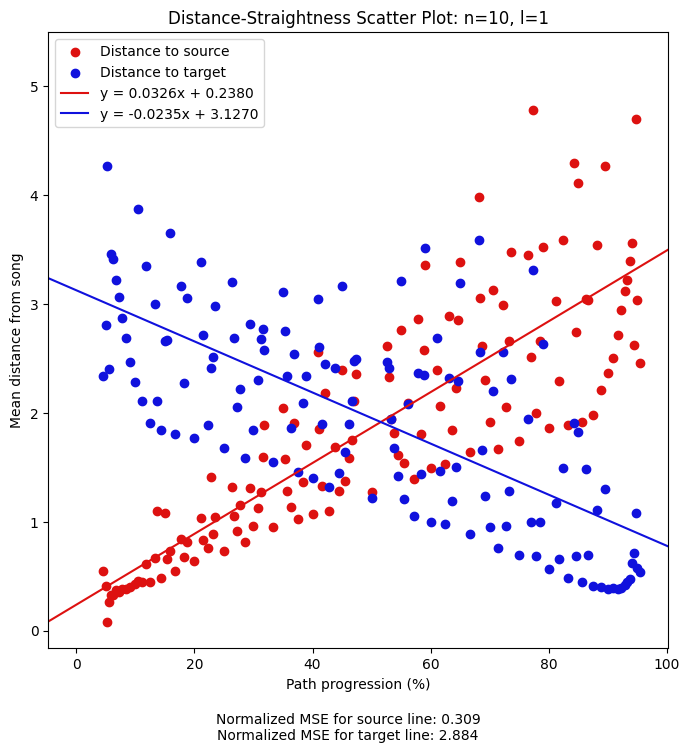

In [38]:
plot_avg_distances(msd_features, 'msd-results/results-n=10-d=10000-l=1', feature_distance_l1, "n=10, l=1")

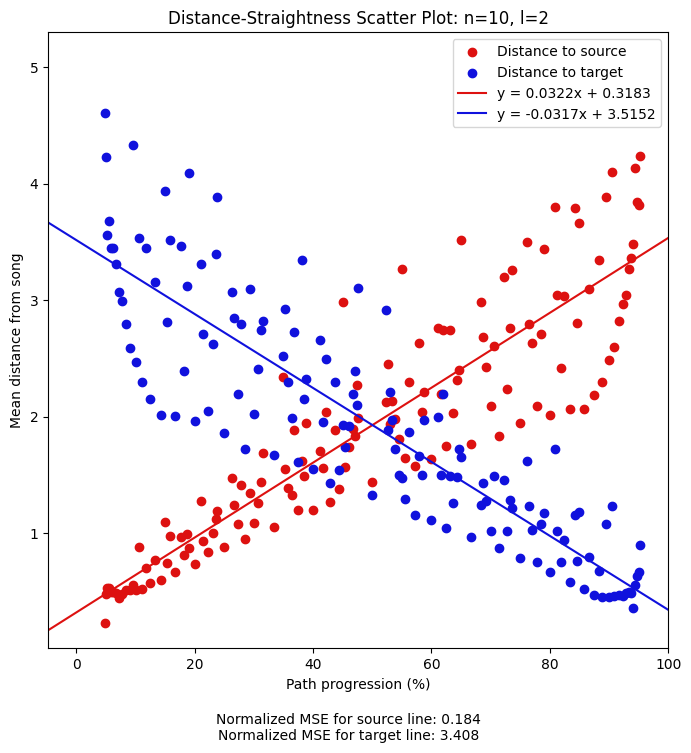

In [39]:
plot_avg_distances(msd_features, 'msd-results/results-n=10-d=10000-l=2', feature_distance_l2, "n=10, l=2")

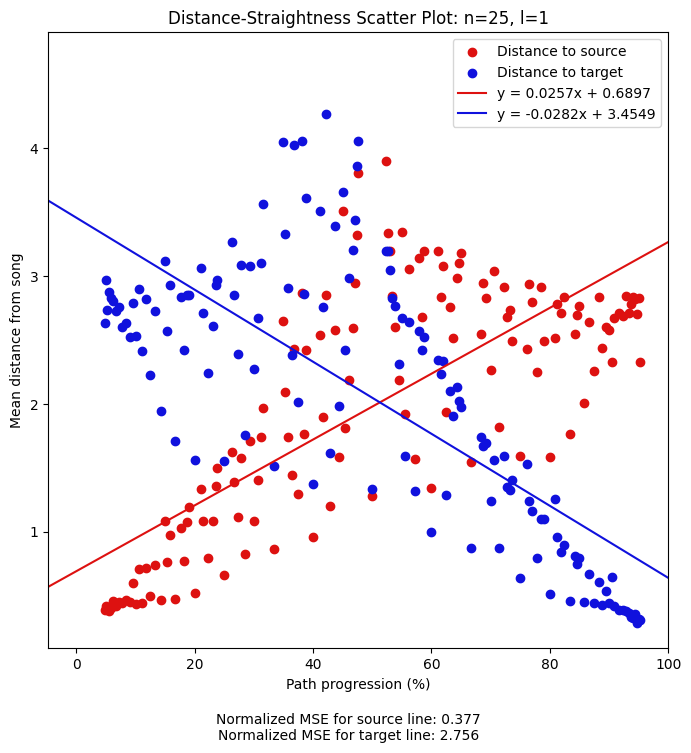

In [40]:
plot_avg_distances(msd_features, 'msd-results/results-n=25-d=10000-l=1', feature_distance_l1, "n=25, l=1")

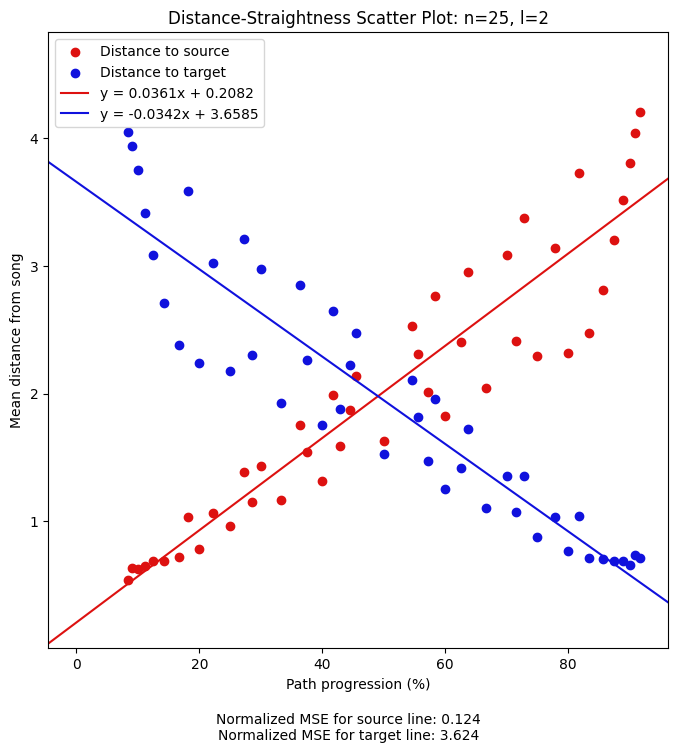

In [41]:
plot_avg_distances(msd_features, 'msd-results/results-n=25-d=10000-l=2', feature_distance_l2, "n=25, l=2")

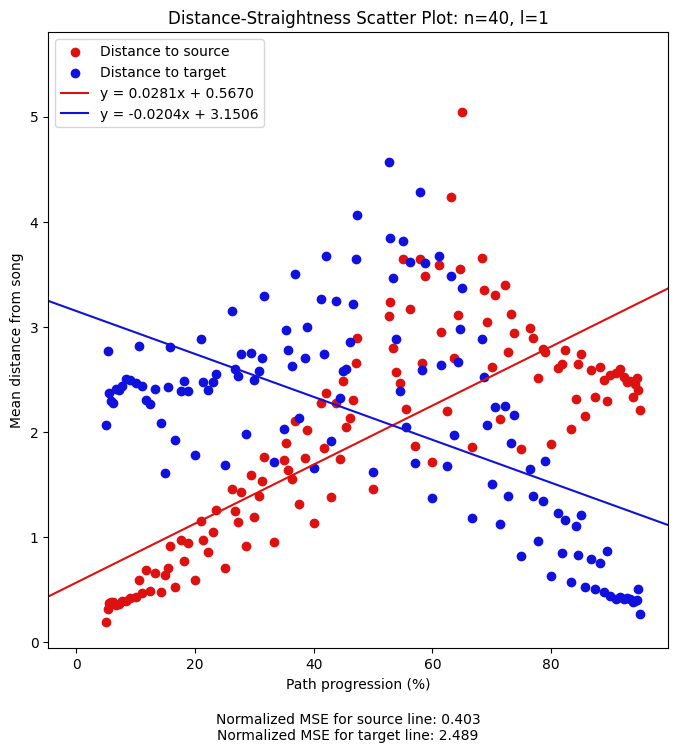

In [42]:
plot_avg_distances(msd_features, 'msd-results/results-n=40-d=10000-l=1', feature_distance_l1, "n=40, l=1")

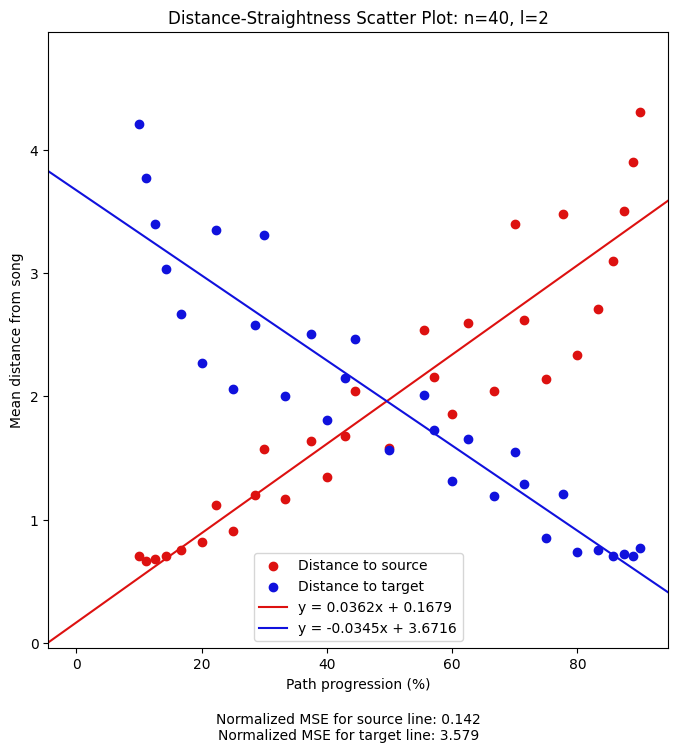

In [43]:
plot_avg_distances(msd_features, 'msd-results/results-n=40-d=10000-l=2', feature_distance_l2, "n=40, l=2")

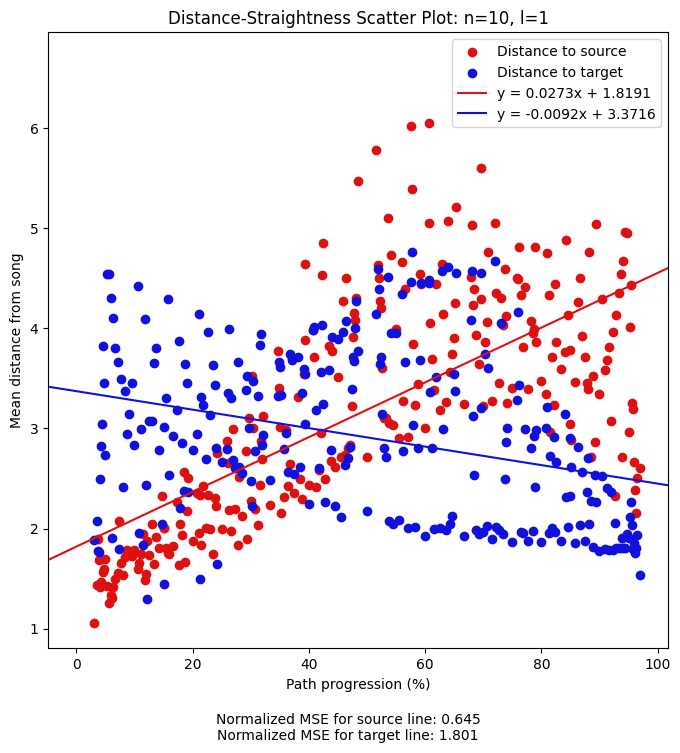

In [44]:
plot_avg_distances(mfcc_features, 'msd-results/results-n=10-d=10000-l=1-f=mfcc', array_distance_l1, "n=10, l=1")

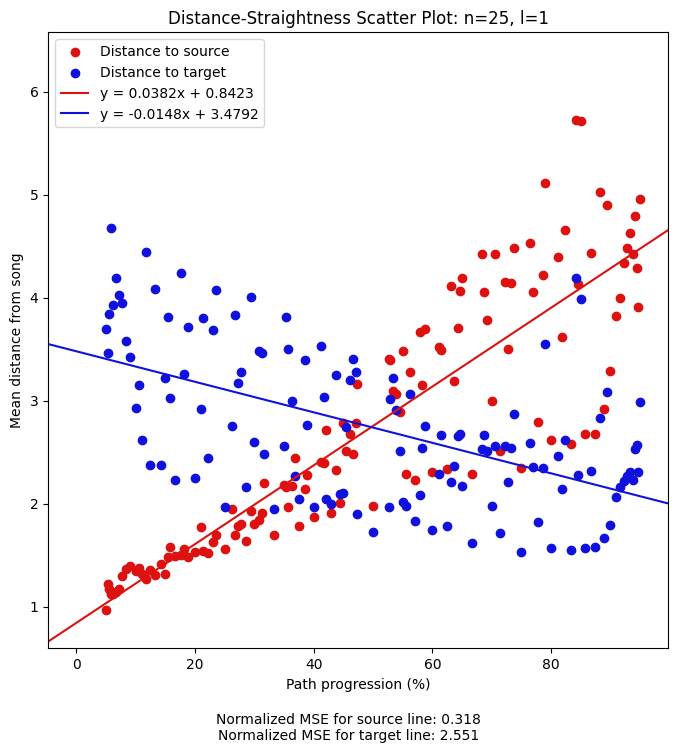

In [45]:
plot_avg_distances(mfcc_features, 'msd-results/results-n=25-d=10000-l=1-f=mfcc', array_distance_l1, "n=25, l=1")

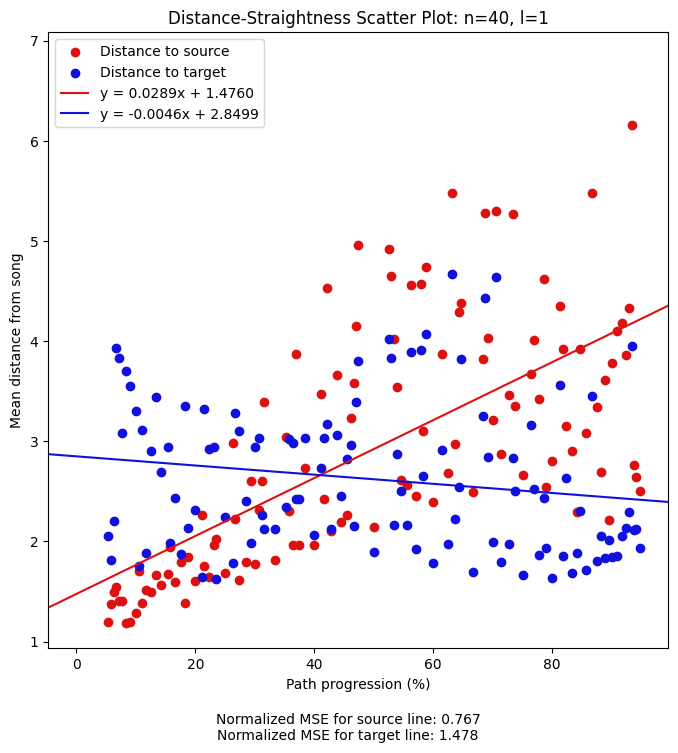

In [46]:
plot_avg_distances(mfcc_features, 'msd-results/results-n=40-d=10000-l=1-f=mfcc', array_distance_l1, "n=40, l=1")